# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача: Построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from itertools import islice

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels[:5]

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


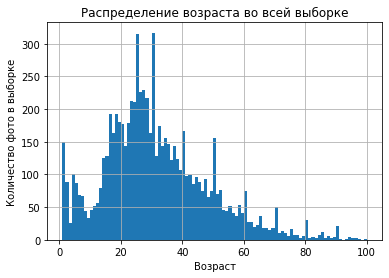

In [ ]:
labels['real_age'].hist(bins=99)
plt.title('Распределение возраста во всей выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество фото в выборке')
plt.show()

In [ ]:
frac = 0.95
low = (1 - frac) / 2
high = 1 - low

qlow = labels['real_age'].quantile(low)
qhigh = labels['real_age'].quantile(high)
print(f"95% возрастов - от {qlow:.0f} до {qhigh:.0f}")

95% возрастов - от 2 до 71


In [ ]:
labels.query('@qlow <= real_age <= @qhigh').describe()

,real_age
count,7260.000000
mean,30.559366
std,14.953173
min,2.000000
25%,20.000000
50%,28.000000
75%,40.000000
max,71.000000


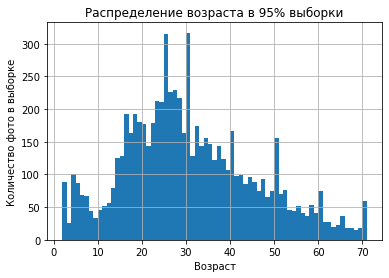

In [ ]:
labels.query('@qlow <= real_age <= @qhigh').hist(bins=round(qhigh-qlow))
plt.title('Распределение возраста в 95% выборки')
plt.xlabel('Возраст')
plt.ylabel('Количество фото в выборке')
plt.show()

Выборка достаточно обширная: 95% всех значений возраста находятся между 2 годами и 71 годом. Больше всего здесь фотографий - людей 25 и 30 лет.

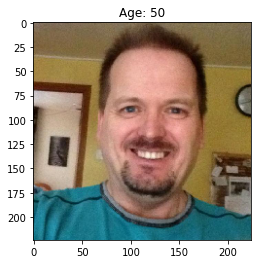

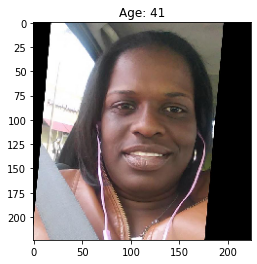

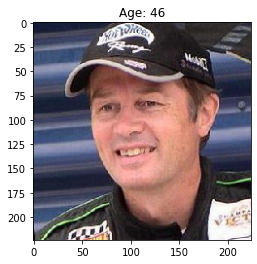

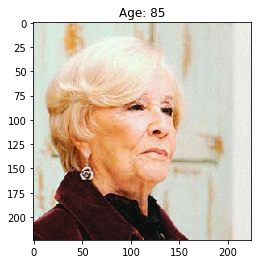

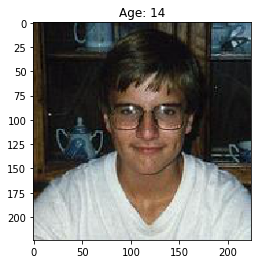

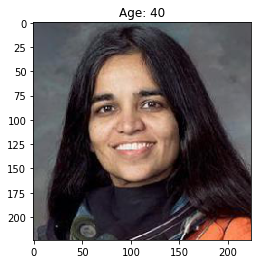

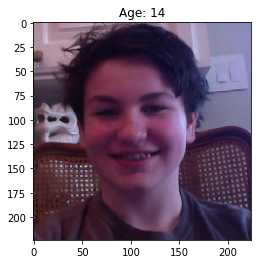

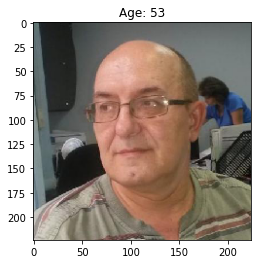

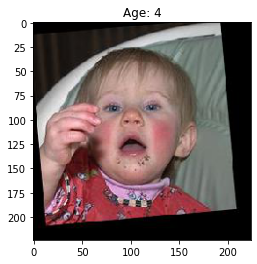

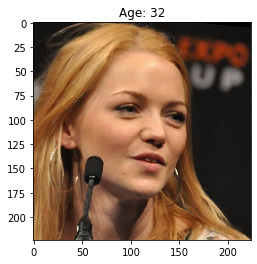

In [ ]:
batch = next(train_gen_flow)
for img, age in islice(zip(batch[0], batch[1]), 10):
    plt.title(f'Age: {age}')
    plt.imshow(img)
    plt.show()

## Обучение модели

Код обучения модели

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

Результат вывода на экран

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-07-19 12:04:08.379901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-19 12:04:08.756788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 51s - loss: 241.8411 - mae: 11.7479 - val_loss: 1050.5071 - val_mae: 29.1395
Epoch 2/10
178/178 - 39s - loss: 154.7082 - mae: 9.4935 - val_loss: 354.8941 - val_mae: 14.0317
Epoch 3/10
178/178 - 39s - loss: 111.9550 - mae: 8.1297 - val_loss: 366.4296 - val_mae: 14.2736
Epoch 4/10
178/178 - 40s - loss: 84.5295 - mae: 7.0678 - val_loss: 324.4767 - val_mae: 13.3318
Epoch 5/10
178/178 - 39s - loss: 64.5000 - mae: 6.2242 - val_loss: 276.5609 - val_mae: 12.5451
Epoch 6/10
178/178 - 39s - loss: 46.2507 - mae: 5.2826 - val_loss: 104.4140 - val_mae: 7.8121
Epoch 7/10
178/178 - 41s - loss: 32.9123 - mae: 4.4318 - val_loss: 111.5068 - val_mae: 7.9172
Epoch 8/10
178/178 - 39s - loss: 24.5420 - mae: 3.8509 - val_loss: 89.3799 - val_mae: 7.2600
Epoch 9/10
178/178 - 39s - loss: 18.6172 - mae: 3.3630 - val_loss: 88.2331 - val_mae: 7.2138
Epoch 10/10
178/178 - 39s - loss: 14.3661 - mae: 2.9075 - val_loss: 84.4856 - val_mae: 7.0373
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 84.4856 - mae: 7.0373
Test MAE: 7.0373
```

## Анализ обученной модели

Модель в среднем ошибается на 7 лет при определении возраста.
Для определения возрастной группы покупателей этого должно быть достаточно.
При продаже алкоголя стоит быть внимательнее, т.к. модель может переоценить возраст покупателя.